# Qualitätsprüfung der Transkriptom-Daten
## Definition 'Ausreißer'
Um später unser Modell mit korrekten Datensätzen zu trainieren, werden hier zunächst die full_raw_counts-Tabellen aller Datensätze um 'Ausreißer' bereinigt.
Unter Ausreißer werden gefasst: 
1.	Fehlende Werte: leere Tabellenzellen
2.	GeneIDs, die zu allen Phasen gleich stark exprimiert werden und somit keine Hilfe für die Klassifikation in früh-mittel-spät bieten
3.	(Falls mehrer Runs in einem Datensatz vorliegen: Auffällige Abweichungen der Expression eines Gens in Relation zu den anderen Runs: Mittelwerte zu jeder GeneID pro Probe und jeweils miteinander vergleichen um „schlechte“ (fehlerhafte Proben, Messfehler, Pippetierfehler) Runs zu filtern) 
4. Host-Sätze, da das Programm auf die Klassifikation der Phagengene abzielt
5. Replikate, die zum Zeitpunkt 0 hohe Expressionswerte aufweisen  

## Detektion
1. Fehlende Werte: pandas NaN
2. GeneIDs, die zu allen Phasen ähnlich (z.B. < 5% Schwankung über alle Phasen) stark exprimiert werden: pandas und statistische Methoden
3. PCA Methode
4. Host-Sätze markieren: pandas
5. Replikate, die zum Zeitpunk 0 hohe Expressionswerte aufweisen durch Heatmap und PCA ermitteln

## Kenntlichmachung
Die markierten count-Tabellen werden im jeweiligen Unterordner data/**/*_full_raw_counts_marked.tsv abgelegt. 
Ausreißer in Tabelle markiert durch 1 in Spalte 'Outlier', genauer:
1. Markierung der leeren Zellen mit -1, 1 in Zeile 'Rows with missing values'
2. Markierung von Genen, deren counts sich über alle Phasen kaum unterscheiden mit 1 in Spalte 'negligible changes'
3. # TODO abweichende Werte zwischen den Replikaten PCA #####TODO
4. Markierung von Host-Genen durch eine 1 in Spalte 'Outlier'
5. Hinzufügen einer Zeile deren Spalte eine 1 zum Zeitpunkt 0 enthält falls der Expressionswert auffällig hoch ist #TODO
Außerdem wird unter "data/marked/overview_marks.txt jeder count-Datensatz unter Angabe der Zahl der Ausreißer aufgeführt.
------------------------------------------------------------------------------------

Aktuelles Arbeitsverzeichnis: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/notebooks
Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Sprenger_VC_WT_VP882_delta_cpdS_full_raw_counts_marked_tpm.tsv
            0_R1        0_R2        0_R3
46    559.738017  451.432410  490.712868
62    154.491298  111.600969  106.227939
308   344.495765  233.583424  238.977024
409   237.956259  197.572646  280.120638
508   177.025035  148.747222  168.875185
...          ...         ...         ...
3456   21.091577   19.140864   22.363777
3476   86.529549   78.185563   69.815123
3557  213.079013  177.945150  182.780867
3571   41.101536   54.502799   59.063308
3608   20.911308   17.356546   23.797352

[71 rows x 3 columns]
▶ Maximaler Wert in Sprenger_VC_WT_VP882_delta_cpdS_full_raw_counts_marked_tpm.tsv: 950.17


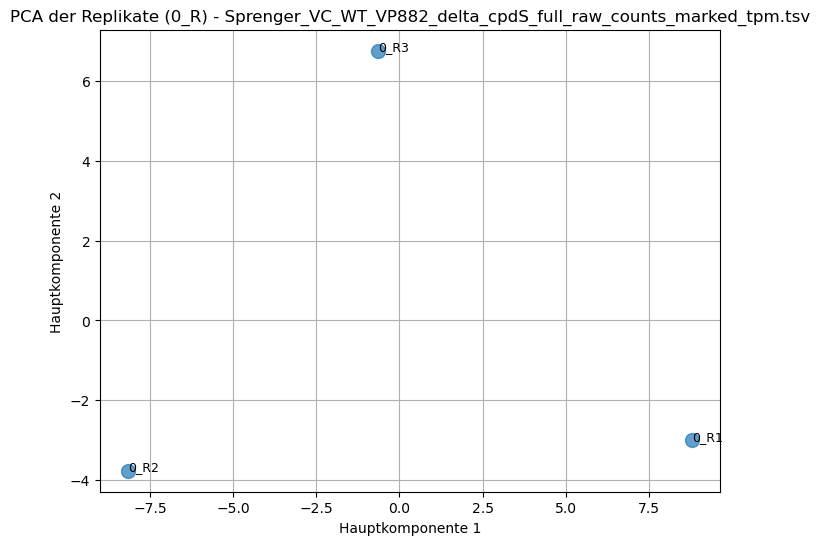

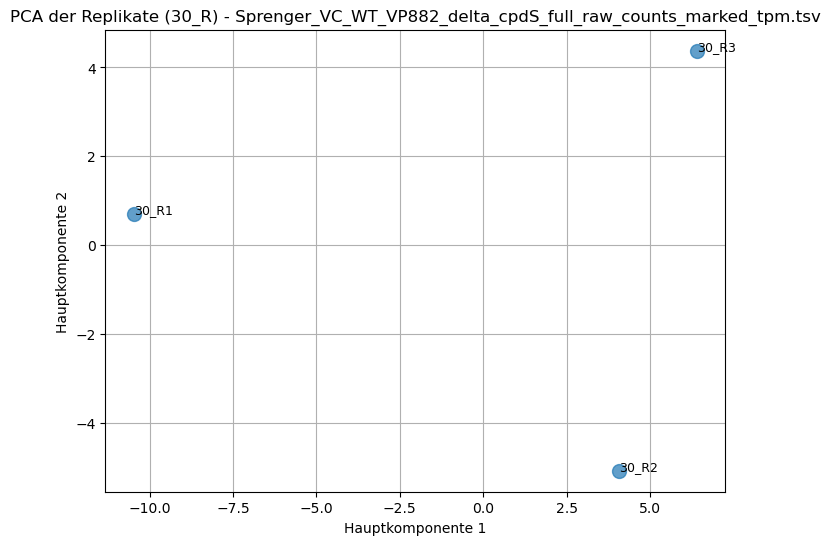

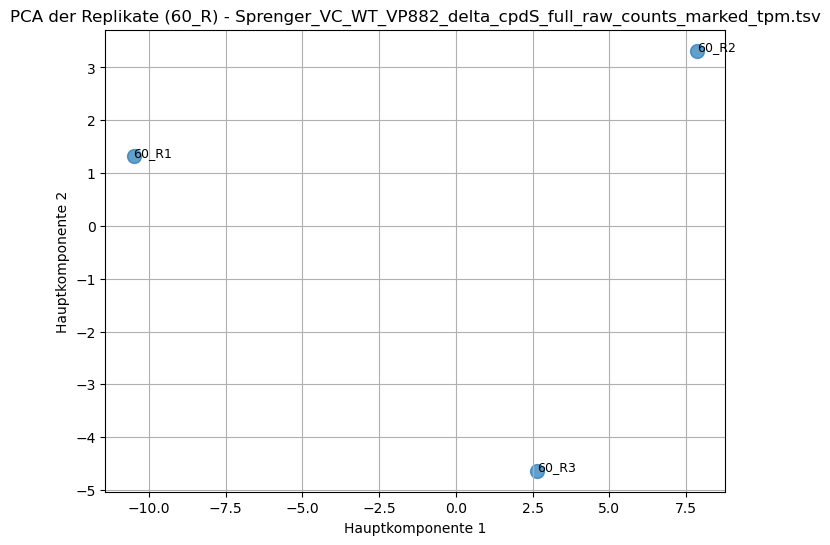

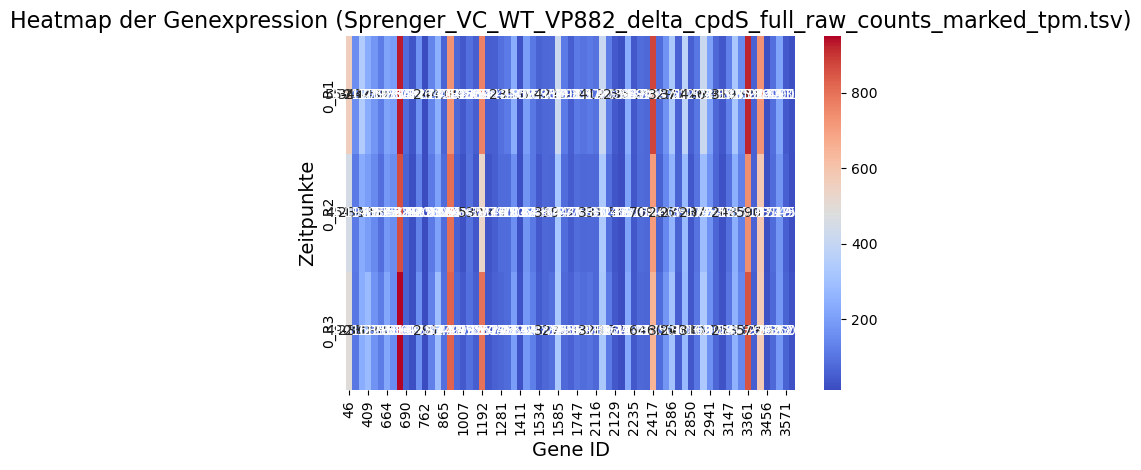

Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Guegler_T4_minusToxIN_full_raw_counts_marked_tpm.tsv
          0_R1      0_R2
5     0.000000  0.000000
28    3.177592  0.151670
36    0.264799  0.000000
55    2.647994  0.050557
81    0.000000  0.000000
...        ...       ...
4725  0.794398  0.000000
4726  0.264799  0.000000
4736  0.000000  0.000000
4756  0.000000  0.000000
4760  0.000000  0.050557

[288 rows x 2 columns]
▶ Maximaler Wert in Guegler_T4_minusToxIN_full_raw_counts_marked_tpm.tsv: 8.74


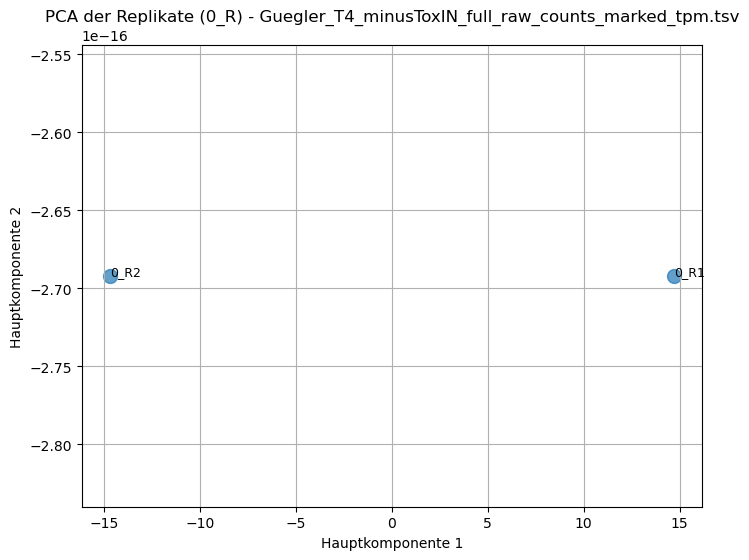

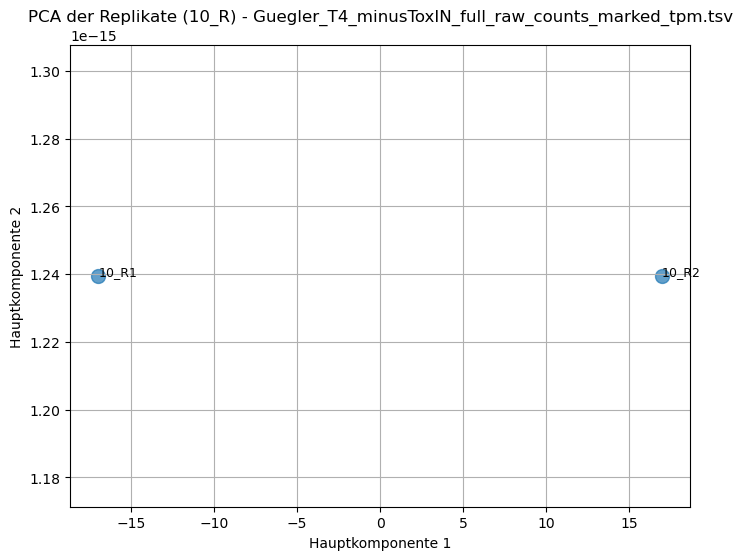

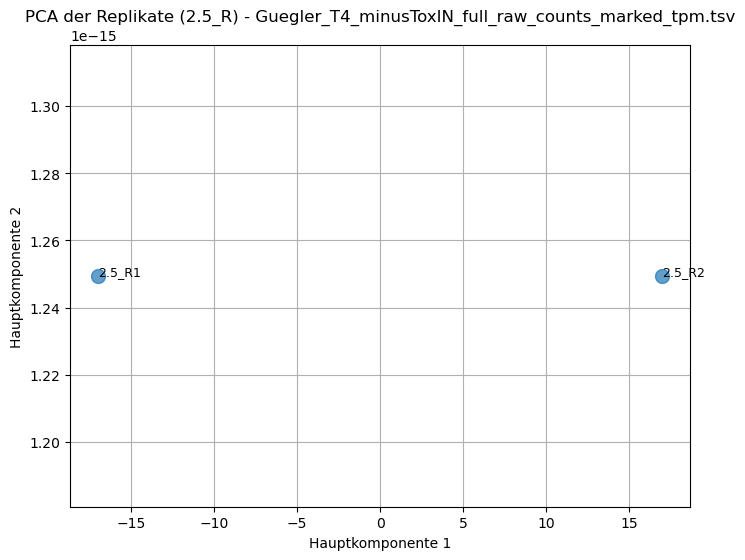

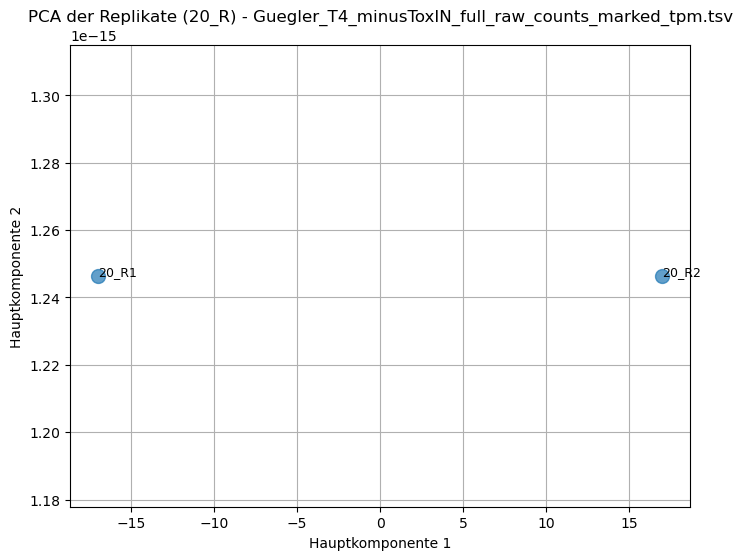

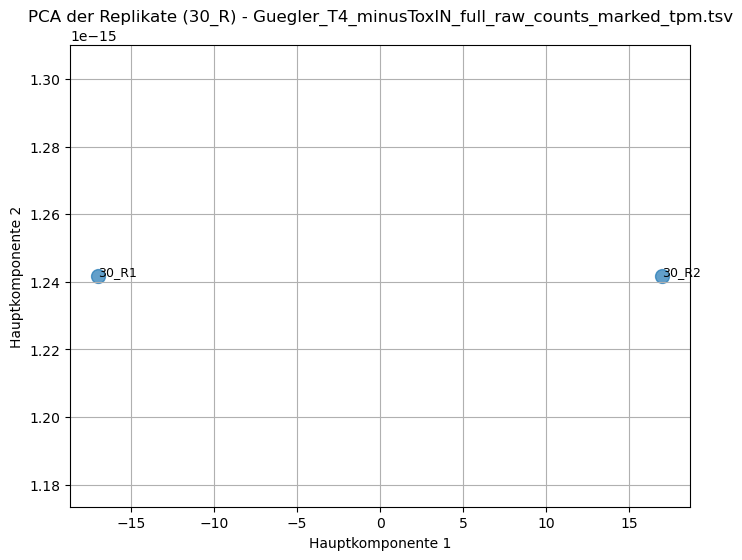

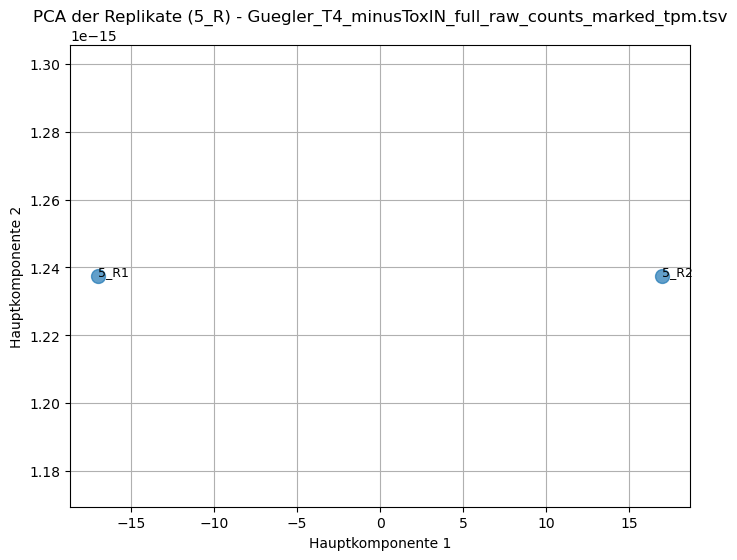

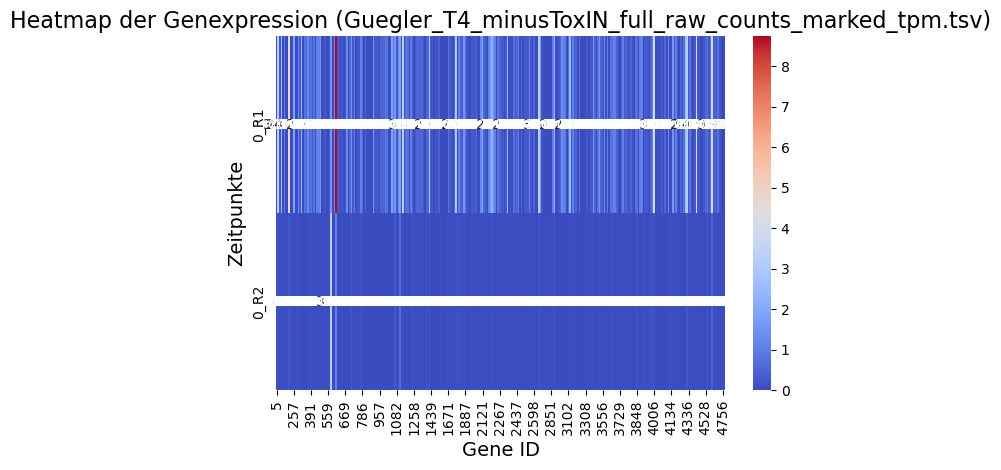

Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Finstrlova_Newman_full_raw_counts_marked_tpm.tsv
          0_R1      0_R2       0_R3
5     0.000000  2.019877   2.239661
6     0.000000  2.019877   2.612938
14    0.320626  6.059630   4.479322
22    0.320626  5.482523   4.479322
25    1.923758  6.059630  17.544010
...        ...       ...        ...
2994  0.641253  4.328307   4.852599
3035  0.000000  0.577108   1.119830
3043  0.000000  1.731323   0.746554
3047  0.000000  0.000000   0.373277
3048  0.320626  1.154215   1.119830

[237 rows x 3 columns]
▶ Maximaler Wert in Finstrlova_Newman_full_raw_counts_marked_tpm.tsv: 34.71


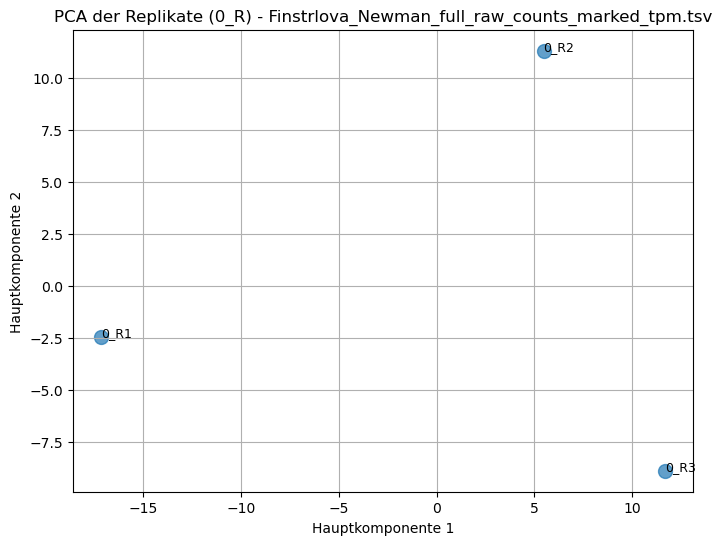

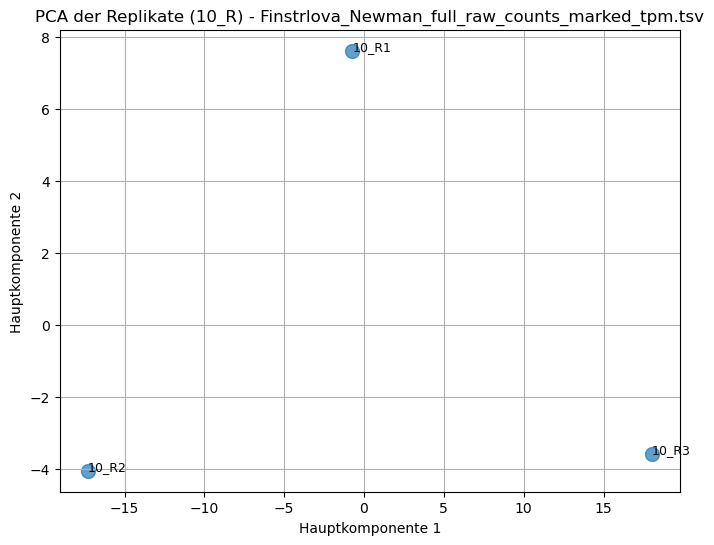

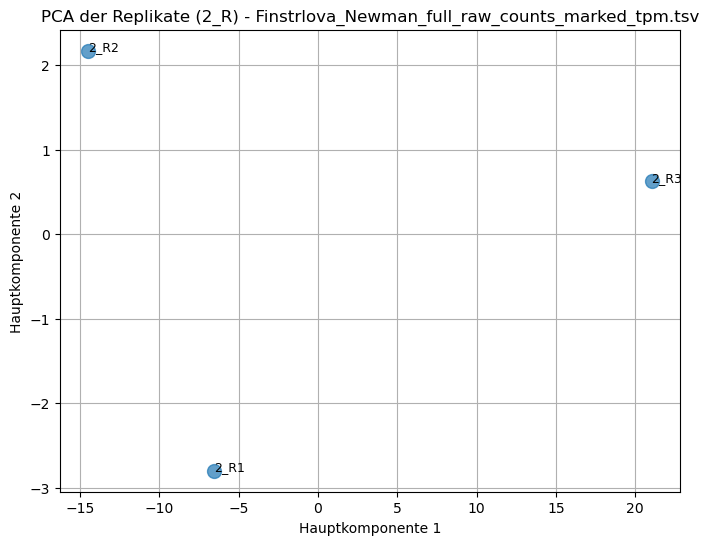

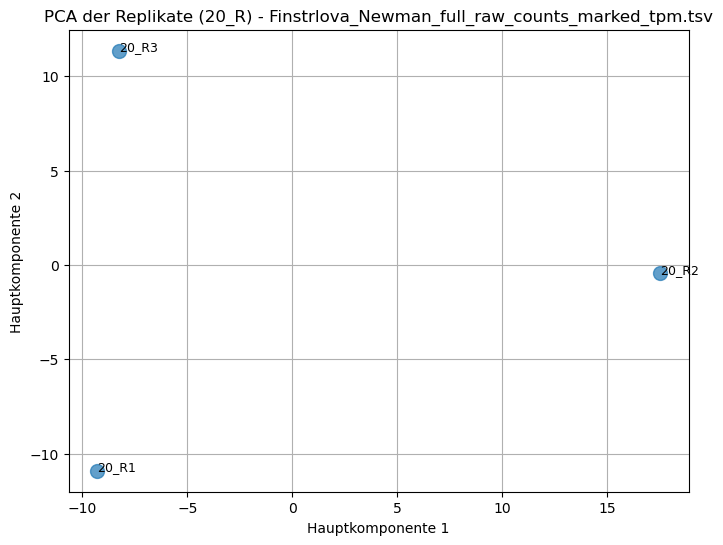

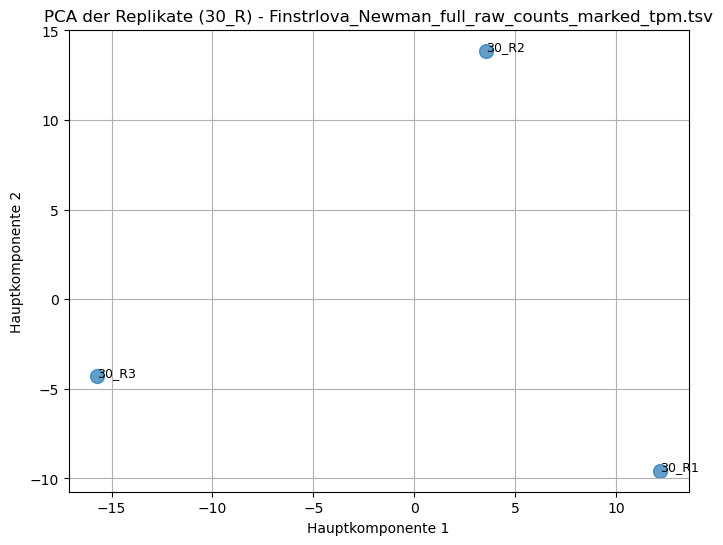

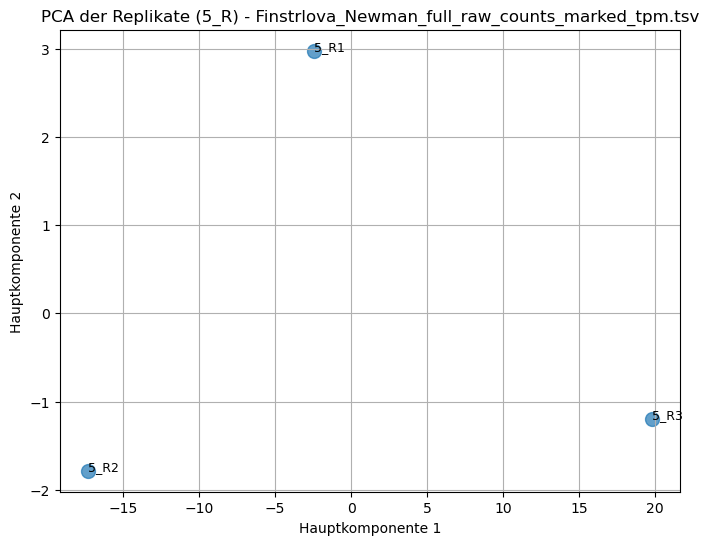

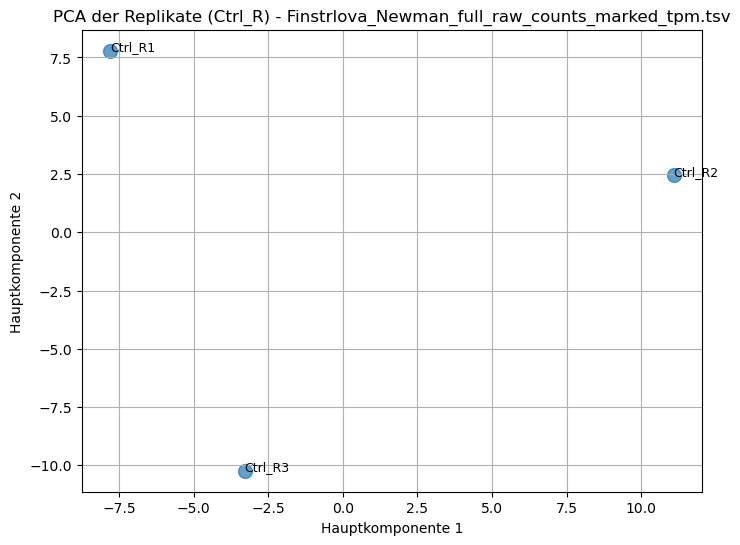

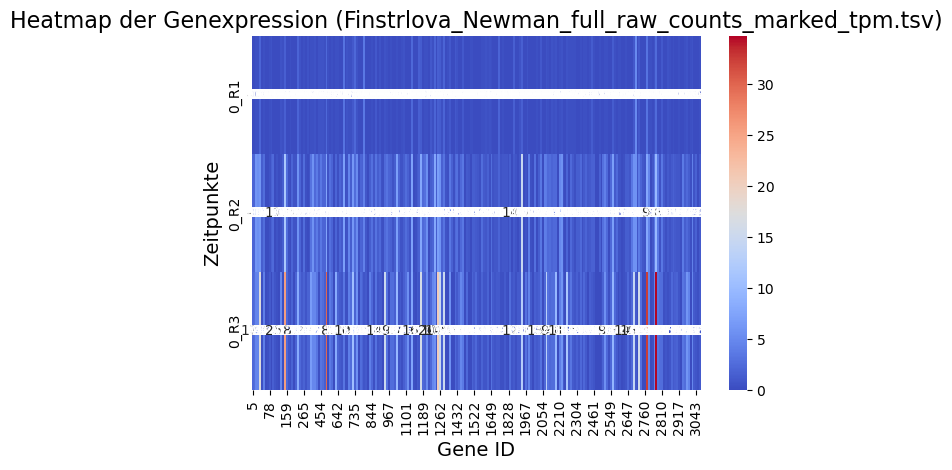

Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Brandao_MCCM_full_raw_counts_marked_tpm.tsv
          0_R1      0_R2
31    1.241693  0.000000
58    0.000000  0.000000
67    0.000000  0.000000
76    0.000000  0.000000
87    0.000000  0.000000
103   0.000000  0.000000
285   0.620847  0.000000
323   0.000000  0.000000
458   0.000000  0.000000
623   0.000000  0.000000
638   0.000000  0.000000
816   0.620847  0.000000
851   3.104233  0.000000
939   0.000000  0.000000
1047  0.000000  0.000000
1065  0.000000  0.000000
1566  0.000000  0.448904
1664  0.620847  0.000000
1683  0.000000  0.000000
1743  0.000000  0.000000
1773  0.000000  0.897808
1989  0.000000  0.448904
2165  0.620847  0.000000
2284  0.000000  0.000000
2425  1.241693  0.000000
2554  0.000000  0.000000
2643  0.000000  0.000000
2660  0.000000  0.000000
2723  0.000000  0.000000
2900  0.000000  0.000000
2939  2.483386  0.000000
3102  0.000000  0.000000
3195  0.000000  0.000000
3439  0.

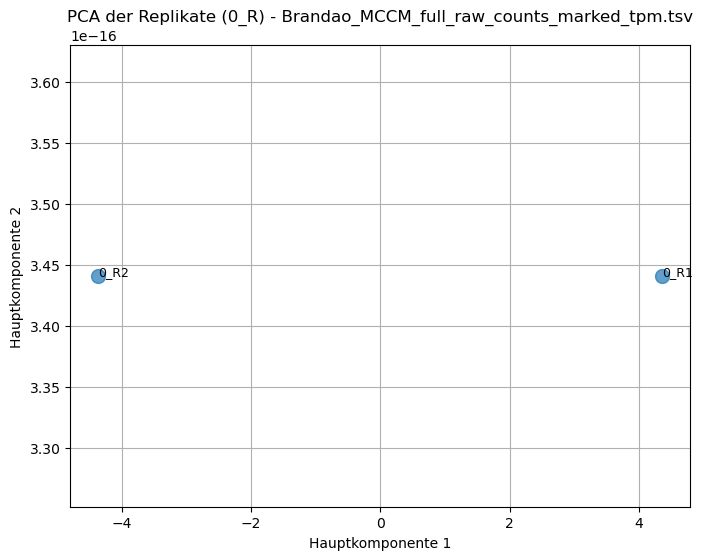

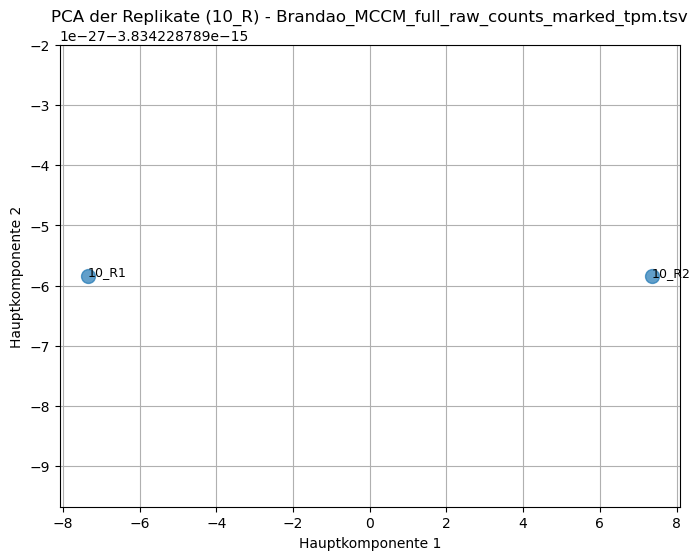

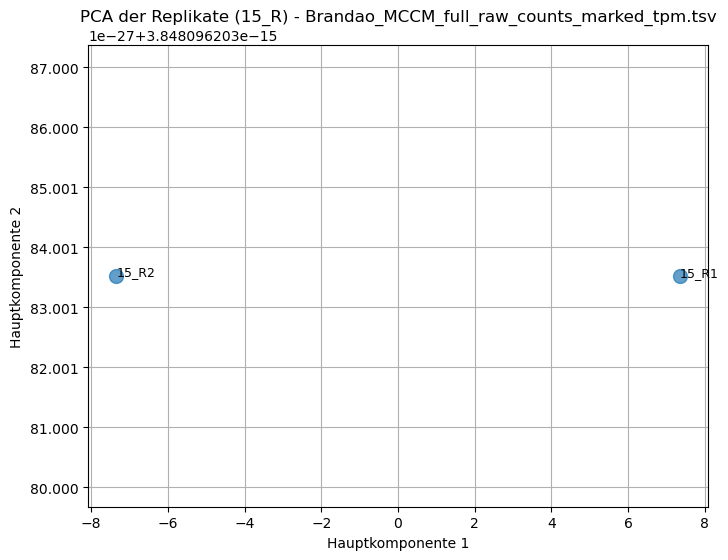

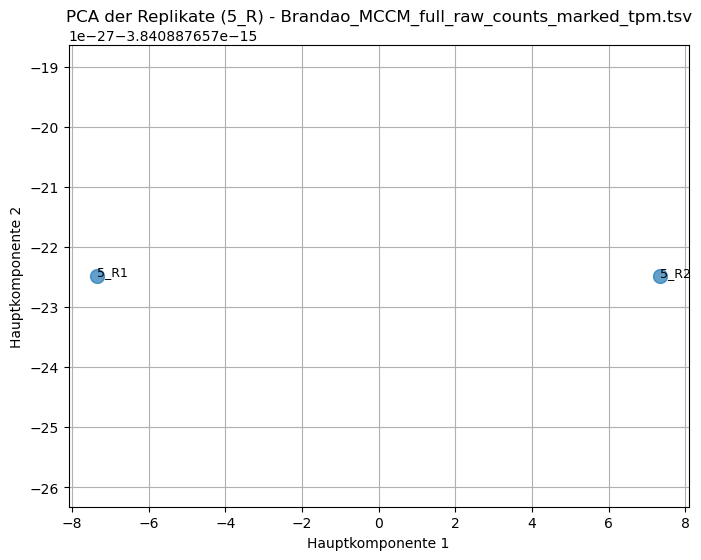

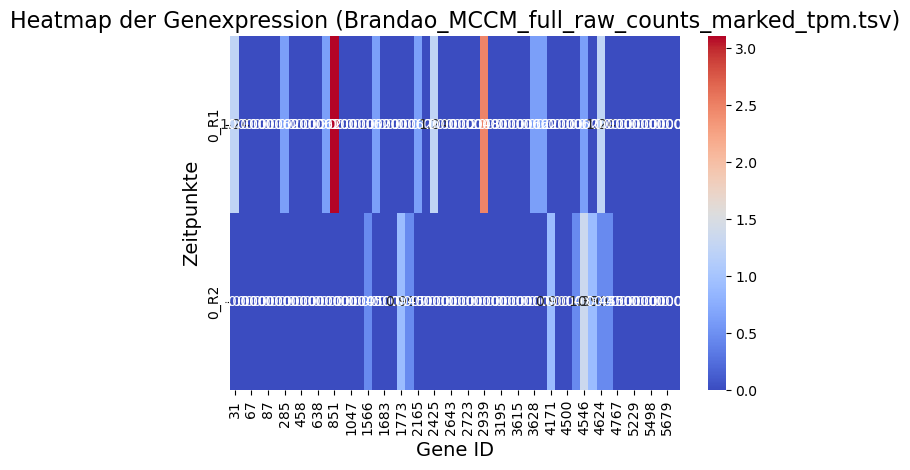

Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Lood_full_raw_counts_marked_tpm.tsv
      0_R1  0_R2  0_R3  0_R4
15     0.0   0.0   0.0   0.0
52     0.0   0.0   0.0   0.0
62     0.0   0.0   0.0   0.0
73     0.0   0.0   0.0   0.0
90     0.0   0.0   0.0   0.0
...    ...   ...   ...   ...
6039   0.0   0.0   0.0   0.0
6057   0.0   0.0   0.0   0.0
6064   0.0   0.0   0.0   0.0
6067   0.0   0.0   0.0   0.0
6096   0.0   0.0   0.0   0.0

[461 rows x 4 columns]
▶ Maximaler Wert in Lood_full_raw_counts_marked_tpm.tsv: 0.57


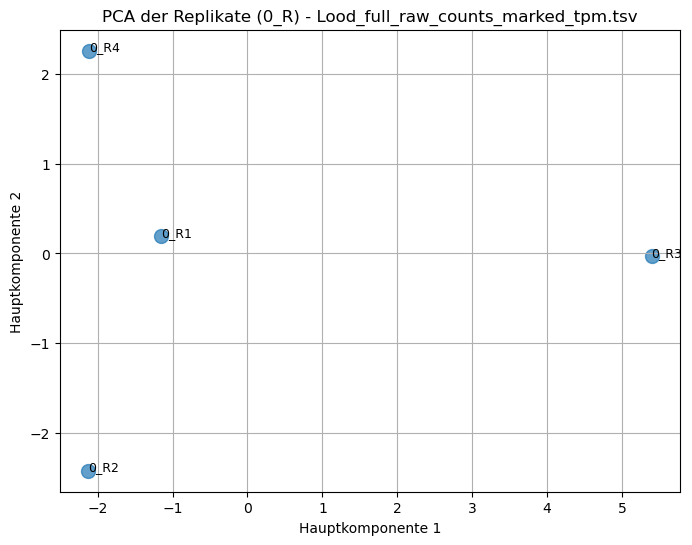

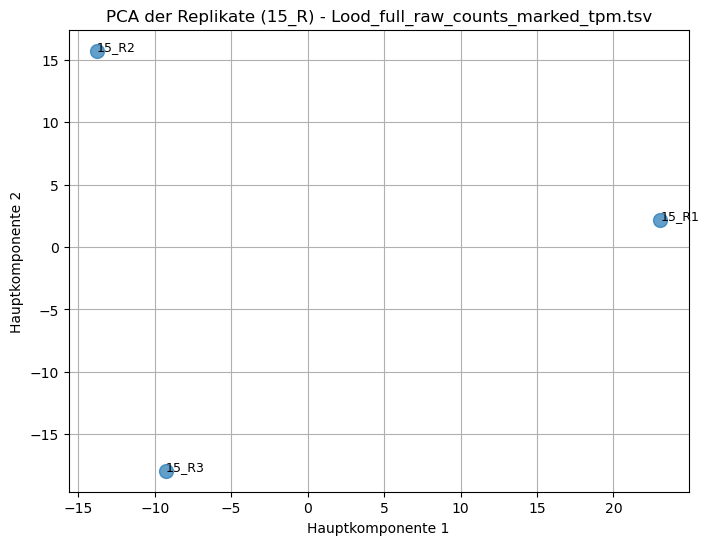

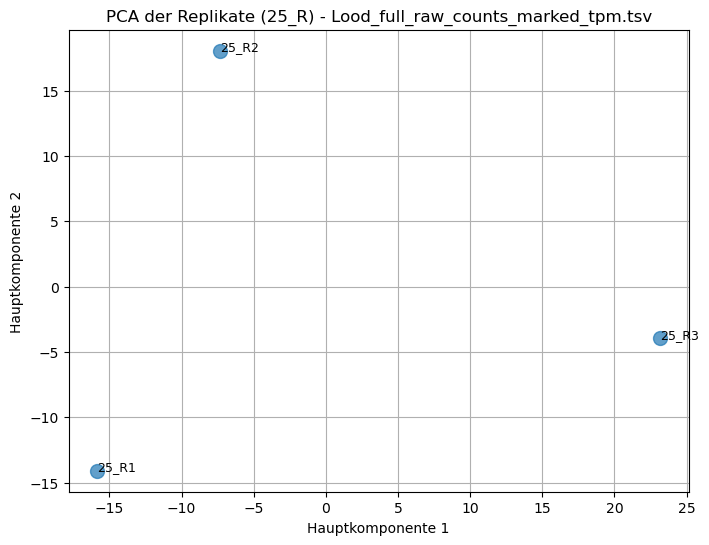

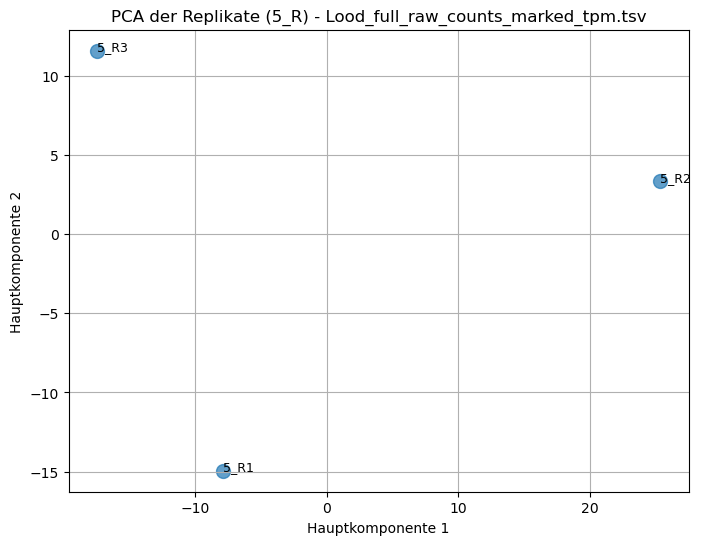

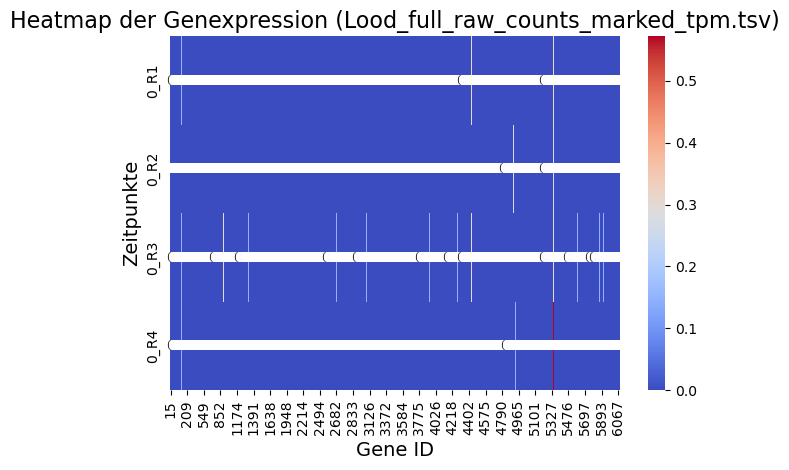

Verarbeite Datei: /home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/Guegler_T7_plusToxIN_full_raw_counts_marked_tpm.tsv
           0_R1      0_R2
214    0.183615  0.092309
248    1.505644  0.738475
274    0.220338  0.246158
297    0.073446  0.123079
306    1.432198  1.046173
337    0.403953  0.123079
355    0.514122  0.338468
409    0.220338  0.153849
509    0.514122  0.184619
622    0.550845  0.892324
663    1.432198  1.476950
675    0.807907  0.307698
776    4.847440  2.984670
846    0.771184  0.338468
870    0.330507  0.523086
1041   0.477399  0.307698
1068   0.514122  0.369238
1134   0.073446  0.246158
1276   0.257061  0.184619
1307   0.330507  0.400007
1587   0.697738  0.400007
1645   0.146892  0.061540
1741   0.477399  0.461547
1791   0.440676  0.400007
1818   0.110169  0.184619
1827   0.036723  0.000000
1961   0.000000  0.030770
1984   0.000000  0.030770
2072   0.073446  0.153849
2295   0.330507  0.092309
2385   1.652536  0.892324
2442   1.285306  0

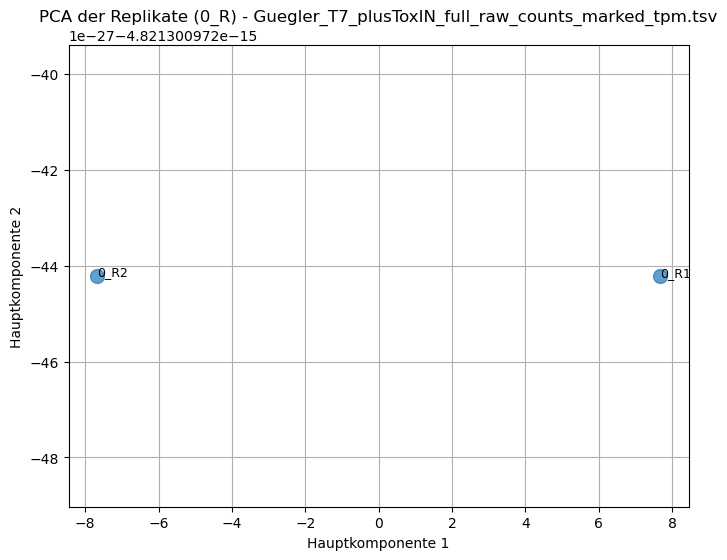

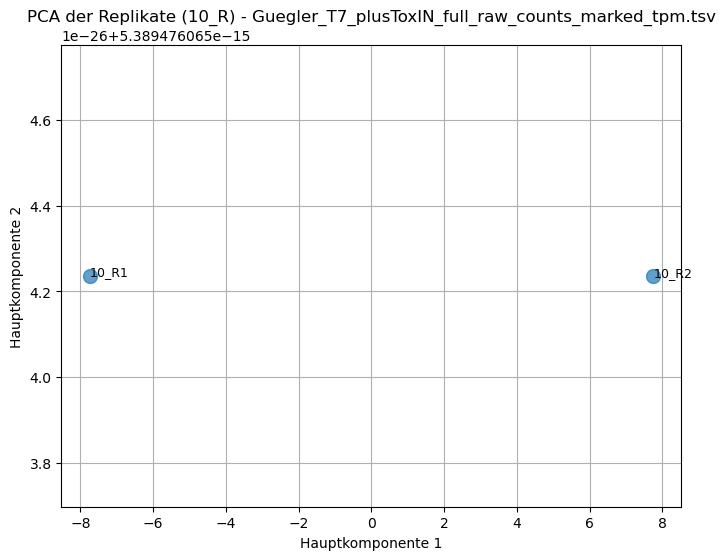

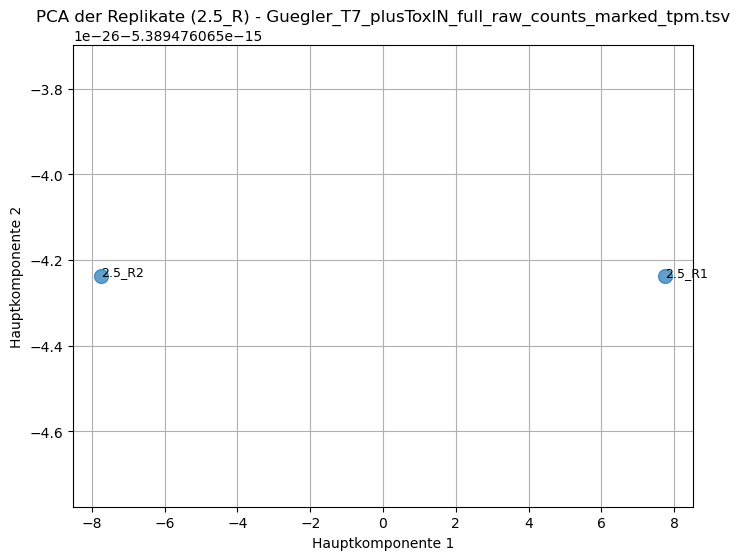

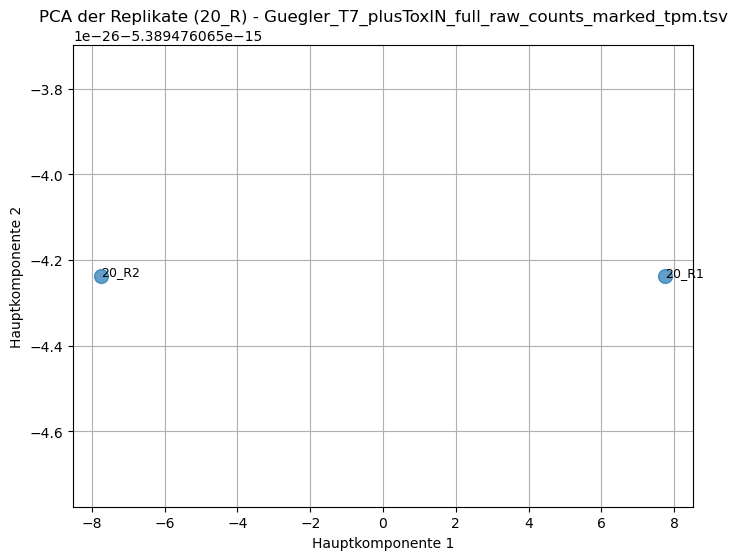

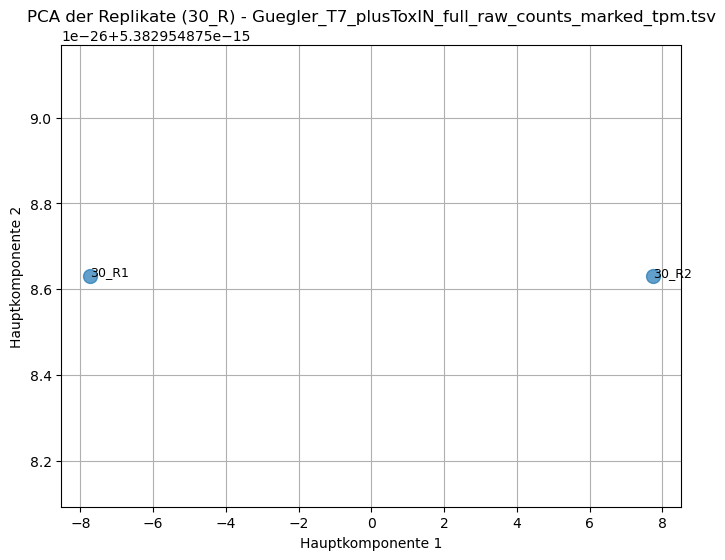

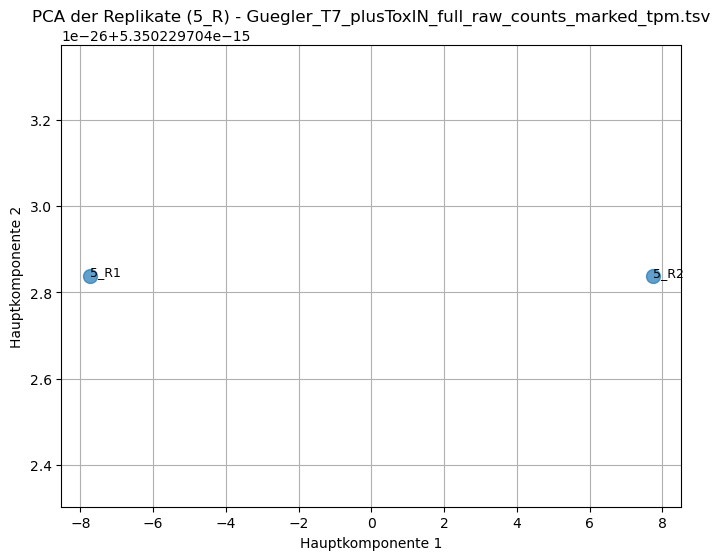

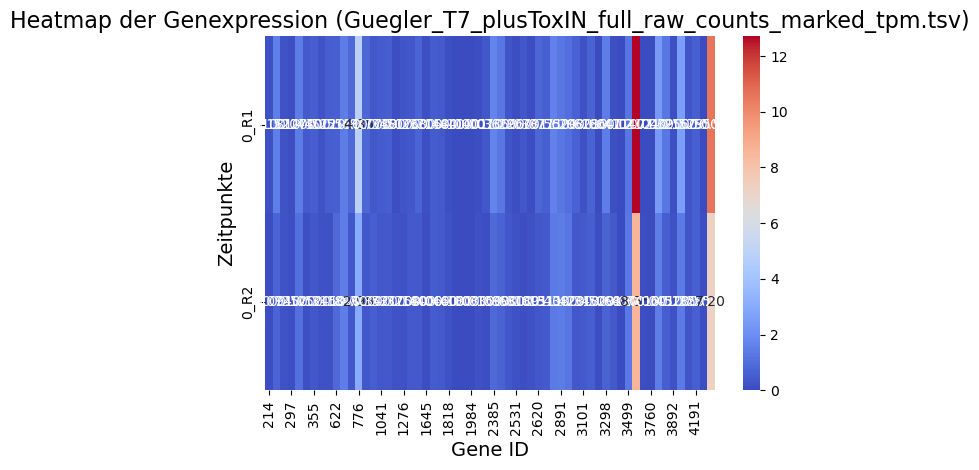

In [ ]:
#Visulasierung der Normalisierten Datensätze zur Detektion der Ausreißer 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import glob
import seaborn as sns

print("Aktuelles Arbeitsverzeichnis:", os.getcwd())

def filter_phage_genes(df):
    # Filtern der Phagen-Gene (bei denen die Spalte 'Entity' den Wert 'phage' enthält)
    return df[df['Entity'] == 'phage']
def filter_time_0(df):
    # Filtern der Spalten, die mit '0_R' beginnen
    time_0_columns = [col for col in df.columns if col.startswith('0_R')]
    # Den DataFrame auf diese Spalten beschränken
    return df[time_0_columns], time_0_columns
def find_max_value(df, time_columns):
    """Gibt den maximalen Wert aus den angegebenen Zeitspalten zurück"""
    if df.empty or not time_columns:
        return None  # Keine Daten vorhanden
    max_value = df[time_columns].max().max()
    return max_value
def perform_pca_and_plot(data, timepoint_label, file_name):
    # Nur die Spalten für den aktuellen Zeitblock auswählen
    timepoint_columns = [col for col in data.columns if col.startswith(timepoint_label)]
    
    if len(timepoint_columns) < 2:
        print(f"Nicht genug Replikate für {timepoint_label} in {file_name}")
        return
    
    # Werte extrahieren + standardisieren
    numerical_data = data[timepoint_columns].values
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data.T)  # Achtung: Transponieren, damit Replikate als Samples
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # DataFrame für Plot
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Replikat'] = timepoint_columns
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, s=100)
    for i, row in pca_df.iterrows():
        plt.text(row['PC1'], row['PC2'], row['Replikat'], fontsize=9)
    
    plt.title(f'PCA der Replikate ({timepoint_label}) - {file_name}')
    plt.xlabel('Hauptkomponente 1')
    plt.ylabel('Hauptkomponente 2')
    plt.grid(True)
    plt.show()

# Laden der Datei 
# !muss zum jeweiligen Pfad geändert werden!!!
folder_path = '/home/milena_hrl/PhagenInfektionsProjekt/vivid-virions/data/datasets_normalized/'
file_path = glob.glob(os.path.join(folder_path, "*.tsv"))

for file_path in file_path[:6]:
    print(f"Verarbeite Datei: {file_path}")
    df = pd.read_csv(file_path, sep='\t')
    # Filtere die Phagen-Gene
    filtered_df = filter_phage_genes(df)
    finalfiltered, time_0_columns = filter_time_0(filtered_df)
    # Ausgabe des gefilterten DataFrames
    print(finalfiltered)
    max_value = find_max_value(finalfiltered, time_0_columns)
    if max_value is not None:
        print(f"▶ Maximaler Wert in {os.path.basename(file_path)}: {max_value:.2f}")
    
    unique_timepoints = sorted(set(col.split('_')[0] for col in filtered_df.columns if '_R' in col))
    # Für jeden Zeitblock (z.B. 0, 1, 2, 3…)
    for timepoint in unique_timepoints:
        timepoint_label = f'{timepoint}_R'
        perform_pca_and_plot(filtered_df, timepoint_label, os.path.basename(file_path))
    
    sns.heatmap(finalfiltered[time_0_columns].T.fillna(0), cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
    # Titel und Achsenbeschriftungen
    plt.title(f'Heatmap der Genexpression ({os.path.basename(file_path)})', fontsize=16)
    plt.xlabel('Gene ID', fontsize=14)
    plt.ylabel('Zeitpunkte', fontsize=14)
    # Plot anzeigen
    plt.tight_layout()
    plt.show()




In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import glob

datasets = [
    "Yang",
    "Sprenger_VC_WT_VP882_delta_cpdS",
    "Lood",
    "Guegler_T7_plusToxIN",
    "Guegler_T4_minusToxIN",
    "Finstrlova_Newman",
    "Brandao_MCCM"
]
os.chdir(os.path.expanduser("~"))
print("Neues Arbeitsverzeichnis:", os.getcwd())

# Sicherstellen, dass ./data und ./data/marked da sind
os.makedirs("data", exist_ok=True)
os.makedirs("data/marked", exist_ok=True)


tsv_dateien = []
for ds in datasets:
    pattern = f"./data/**/{ds}_full_raw_counts.tsv"
    tsv_dateien.extend(glob.glob(pattern, recursive=True))
threshold = 0.05 # Schwellenwert, wenn Varianz < Schwellenwert wird das Gen als vernachlässigbar eingestuft

def detect_empty_cells(df):
    ''' 
    Markiert leere Zellen mit -1,
    gibt den DataFrame zurück, die Gesamtzahl der leeren Zellen
    und ein Array (Liste), das für jede Spalte speichert, ob dort mindestens eine leere Zelle war (1) oder nicht (0)
    '''
    missing_values = df.isna().sum().sum()
    # Array: 1 falls mindestens eine NaN in der Spalte, sonst 0
    columns_with_missing = ["Replicates with missing value"] + df.iloc[:, 1:].isna().any(axis=0).astype(int).tolist()
    df = df.fillna(-1)
    return df, missing_values, columns_with_missing

def detect_relative_changes(df, count_cols, threshold):
    '''
    berechnet, wie stark die Daten innerhalb einer Zeile (also eines Gens über die gesamte Dauer) variiert
    '''
    relative_changes = [] # Wert für jede Zeile, wie stark Expression des Gens variiert über die Zeit
    negligible_changes = [] # für jede Zeile 1 wenn Wert weniger als der angegebene Schwellenwert variiert, sonst 0
    for _, row in df.iterrows():
        numbers = []
        for val in row[count_cols]:
            try:
                numbers.append(float(val))
            except ValueError:
                continue
        if numbers and np.mean(numbers) != 0:
            mean = np.mean(numbers)
            std = np.std(numbers)
            relation = std / mean
            relative_changes.append(relation)
            negligible_changes.append(1 if relation < threshold else 0) # wenn Varianz kleiner als Schwellenwert wird die Zeile als vernachlässigbar bewertet
        else:
            relative_changes.append(0)
            negligible_changes.append(0)
    return relative_changes, negligible_changes


def collect_outlier_genes(df):
    '''
    ergänzt Spalte 'Outlier' und markiert dort alle Zeilen/Gene mit 1, in denen Host Gene sind oder eine zu niedrige Varianz aufweisen.
    '''
    df["Outlier"] = (
    (df["negligible changes"] == 1) |
    (df["Entity"] == "host") # Outlier auch, wenn in Spalte 'entity' 'host' steht
    ).astype(int)
    return df

def save_table(df, original_path, suffix="_marked.tsv"):
    '''
    speichert DataFrame im Ordner data/marked als _marked.tsv
    '''
    outdir = "data/marked"
    os.makedirs(outdir, exist_ok=True)
    basename = os.path.basename(original_path)
    outname = os.path.join(outdir, basename.replace('.tsv', suffix))
    df.to_csv(outname, sep='\t', index=False, encoding='utf-8')
    return outname

quality_information = [] # sammelt für jeden Datensatz das Vorkommen von Ausreißern


for datei in tsv_dateien:
    count_table = df = pd.read_csv(datei, sep='\t')
    count_table, missing_values, columns_with_missing = detect_empty_cells(count_table)
    count_cols = count_table.columns[1:-2] # Counts liegen von Spalte 1 bis -2. Annahme: Die erste Spalte gibt GeneID an, die letzten beiden sind Textspalten (in allen raw_counts Tabellen). 
    relative_changes, negligible_changes = detect_relative_changes(count_table, count_cols, threshold)
    count_table["relative changes"] = relative_changes # hängt als Spalte an
    count_table["negligible changes"] = negligible_changes # hängt als Spalte an 
    while len(columns_with_missing) < len(count_table.columns):# um die ergänzten Spalten erweitern 
        columns_with_missing.append(0)
    count_table.loc[len(count_table)] = columns_with_missing    
    negligible_genes = sum(negligible_changes)
    quality_information.append(
        f"{datei}: missing values: {missing_values}, negligible genes: {negligible_genes}"
    )
    count_table = collect_outlier_genes(count_table)
    save_table(count_table, datei)

with open("data/marked/overview_marks.txt", "w") as f:
    for line in quality_information:
        f.write(line + "\n")











Neues Arbeitsverzeichnis: /home/milena_hrl
[]
